In [2]:
import pandas as pd
from sqlalchemy import create_engine


In [3]:
import urllib
from sqlalchemy import create_engine

user = "sa"
password = "***"
server = "localhost"
port = 1433  # o el puerto que hayas mapeado
database = "OULAD"

# Formato del string de conexión
conn_str = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server},{port};DATABASE={database};UID={user};PWD={password}"

# Codificar para que sqlalchemy no falle
params = urllib.parse.quote_plus(conn_str)

# Crear el engine
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")


Inicio del ETL

In [4]:
# Leer tablas desde SQL Server
courses = pd.read_sql_query("SELECT * FROM dbo.courses", con=engine)
assessments = pd.read_sql_query("SELECT * FROM dbo.assessments", con=engine)
vle = pd.read_sql_query("SELECT * FROM dbo.vle", con=engine)
studentInfo = pd.read_sql_query("SELECT * FROM dbo.studentInfo", con=engine)
studentAssessment = pd.read_sql_query("SELECT * FROM dbo.studentAssessment", con=engine)
studentRegistration = pd.read_sql_query("SELECT * FROM dbo.studentRegistration", con=engine)
studentVle = pd.read_sql_query("SELECT * FROM dbo.studentVle", con=engine)

 Agregar columnas ordinales a studentInfo:

In [20]:

# Ordinal para resultado final
studentInfo["final_result_ordinal"] = studentInfo["final_result"].map({
    "Fail": 0, "Withdrawn": 1, "Pass": 2, "Distinction": 3
})

# Ordinal para discapacidad
studentInfo["disability_ordinal"] = studentInfo["disability"].map({"N": 0, "Y": 1})

# ordinal para age_band
studentInfo["age_band_ordinal"] = studentInfo["age_band"].map({
    "0-35": 0,
    "35-55": 1,
    "55<=": 2
})

# ordinal para imd_band
imd_order = {
    "0-10%": 0, "10-20%": 1, "20-30%": 2, "30-40%": 3, "40-50%": 4,
    "50-60%": 5, "60-70%": 6, "70-80%": 7, "80-90%": 8, "90-100%": 9
}
studentInfo["imd_band_ordinal"] = studentInfo["imd_band"].map(imd_order)

# ordinal para highest_education
edu_order = {
    "No Formal quals": 0,
    "Lower Than A Level": 1,
    "A Level": 2,
    "HE Qualification": 3,
    "Post Graduate Qualification": 4
}
studentInfo["highest_education_ordinal"] = studentInfo["highest_education"].map(edu_order)



Cargando tablas full domain creadas

In [21]:
assessment_type_domain = pd.read_sql_query("SELECT * FROM dbo.assessment_type_domain", con=engine)
module_domain = pd.read_sql_query("SELECT * FROM dbo.module_domain", con=engine)
presentation_domain = pd.read_sql_query("SELECT * FROM dbo.presentation_domain", con=engine)
activity_type_domain = pd.read_sql_query("SELECT * FROM dbo.activity_type_domain", con=engine)
week_range_domain = pd.read_sql_query("SELECT * FROM dbo.week_range_domain", con=engine)


In [22]:
# ¿Hay registros en assessments con tipos no válidos?
invalid_assessment_types = assessments[~assessments["assessment_type"].isin(assessment_type_domain["assessment_type"])]
print(f"Registros inválidos en assessment_type: {len(invalid_assessment_types)}")


Registros inválidos en assessment_type: 0


In [23]:
# ¿Hay activity_type que no están en el dominio?
invalid_activities = vle[~vle["activity_type"].isin(activity_type_domain["activity_type"])]
print(f"Tipos de actividad no válidos: {len(invalid_activities)}")


Tipos de actividad no válidos: 0


Inicio EDA

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt


Tipos de assessments

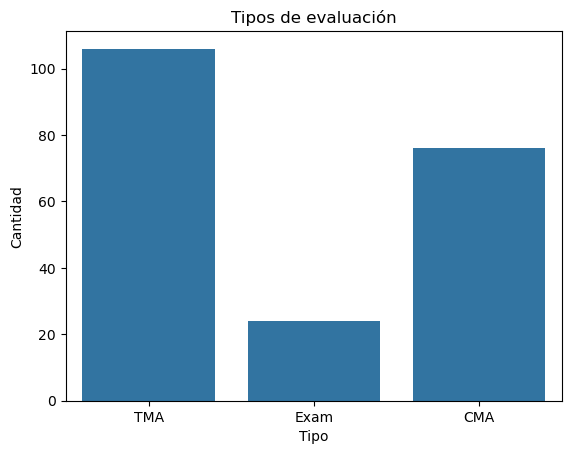

In [25]:
sns.countplot(data=assessments, x="assessment_type")
plt.title("Tipos de evaluación")
plt.xlabel("Tipo")
plt.ylabel("Cantidad")
plt.show()

 Resultados finales (studentInfo)

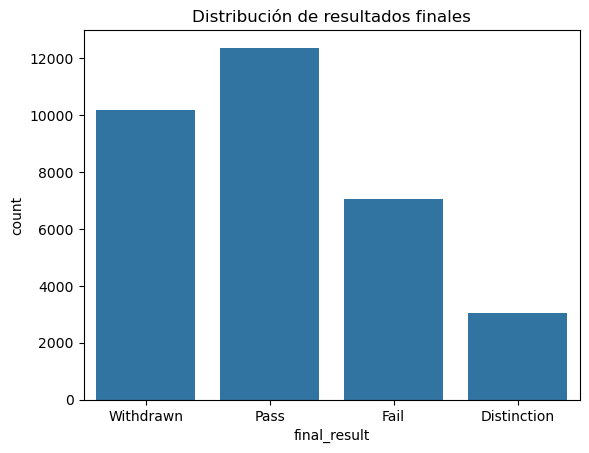

In [26]:
sns.countplot(data=studentInfo, x="final_result")
plt.title("Distribución de resultados finales")
plt.show()


Boxplot: créditos según resultado final

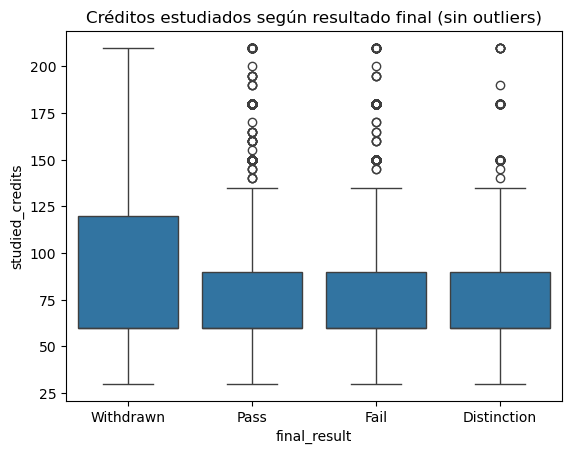

In [27]:
Q1 = studentInfo["studied_credits"].quantile(0.25)
Q3 = studentInfo["studied_credits"].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

studentInfo_clean = studentInfo[(studentInfo["studied_credits"] >= limite_inferior) &
                                (studentInfo["studied_credits"] <= limite_superior)]

sns.boxplot(data=studentInfo_clean, x="final_result", y="studied_credits")
plt.title("Créditos estudiados según resultado final (sin outliers)")
plt.show()


Correlación entre variables ordinales

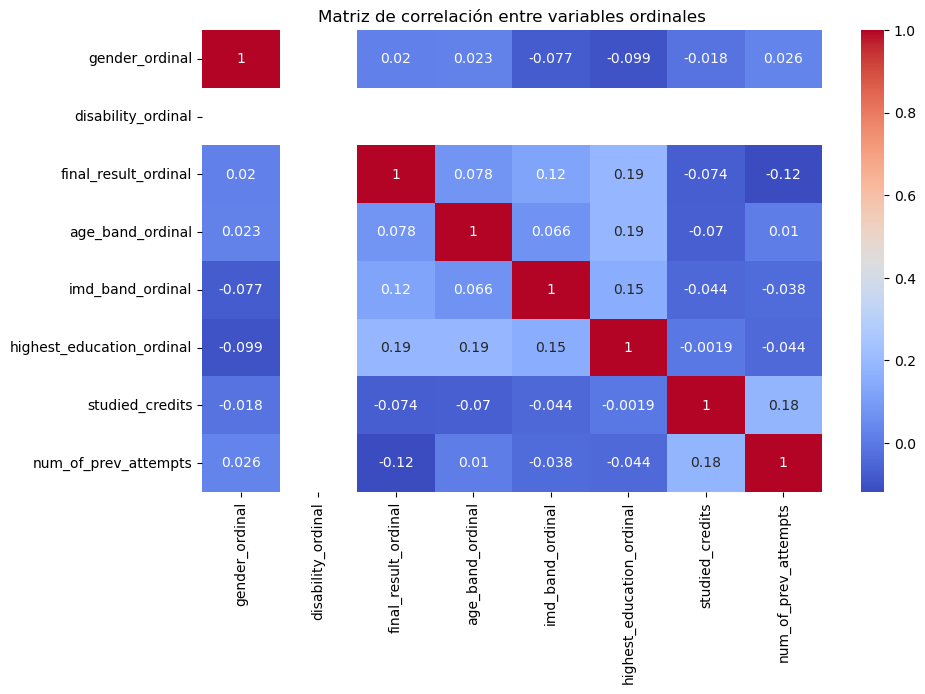

In [28]:
# Seleccionamos columnas ordinales
ordinales = [
    "gender_ordinal", "disability_ordinal", "final_result_ordinal",
    "age_band_ordinal", "imd_band_ordinal", "highest_education_ordinal",
    "studied_credits", "num_of_prev_attempts"
]

# Matriz de correlación
corr = studentInfo[ordinales].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación entre variables ordinales")
plt.show()


Dispersión (scatter): créditos vs intentos previos

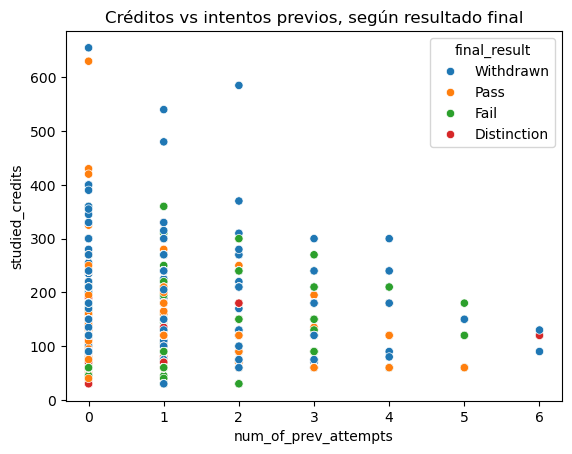

In [29]:
sns.scatterplot(data=studentInfo, x="num_of_prev_attempts", y="studied_credits", hue="final_result")
plt.title("Créditos vs intentos previos, según resultado final")
plt.show()


Campana de Gauss: distribución de créditos

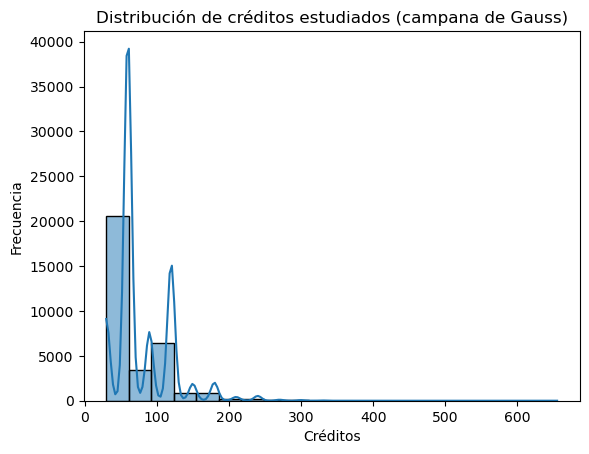

In [30]:
sns.histplot(studentInfo["studied_credits"], kde=True, bins=20)
plt.title("Distribución de créditos estudiados (campana de Gauss)")
plt.xlabel("Créditos")
plt.ylabel("Frecuencia")
plt.show()


Matriz de confusión (modelo básico)

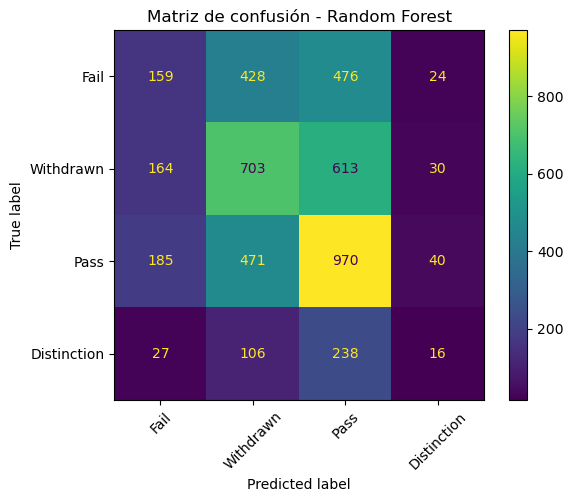

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["Fail", "Withdrawn", "Pass", "Distinction"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Matriz de confusión - Random Forest")
plt.show()


Scatter plot con color por clase

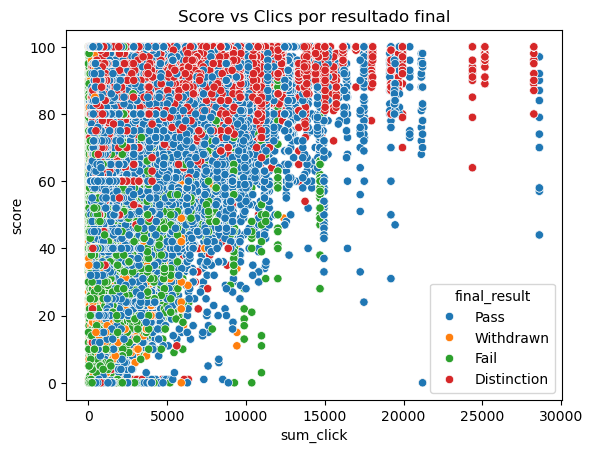

In [33]:
# Opcional: unir score y clics si lo necesitas
studentVle_sum = studentVle.groupby("id_student")["sum_click"].sum().reset_index()
merged = studentAssessment.merge(studentInfo, on="id_student").merge(studentVle_sum, on="id_student")

sns.scatterplot(data=merged, x="sum_click", y="score", hue="final_result")
plt.title("Score vs Clics por resultado final")
plt.show()
